In [1]:
%load_ext autoreload
import ais_predict.datasets.bigquery as bq
import matplotlib.pyplot as plt
import geopandas as gpd
plt.rcParams["figure.figsize"] = (14, 10)

<AxesSubplot:>

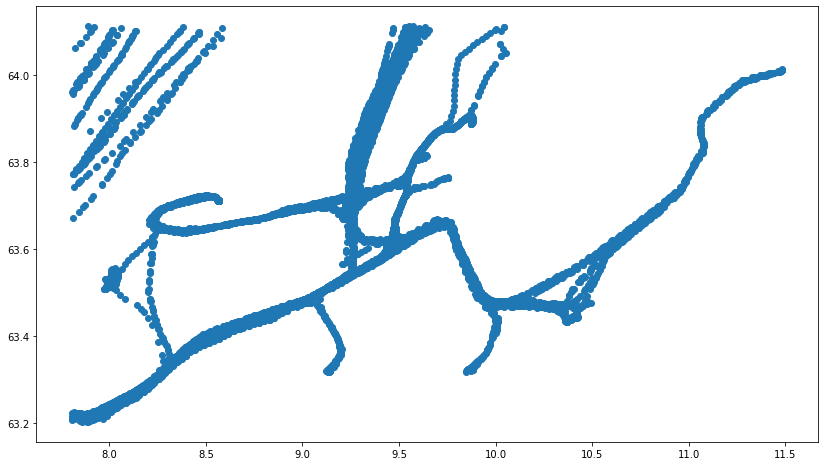

In [2]:
df = bq.download(limit=10000, lead=1)
df.position.plot()

#plt.xlim([200, 250])
#plt.ylim([25, 75])

<AxesSubplot:>

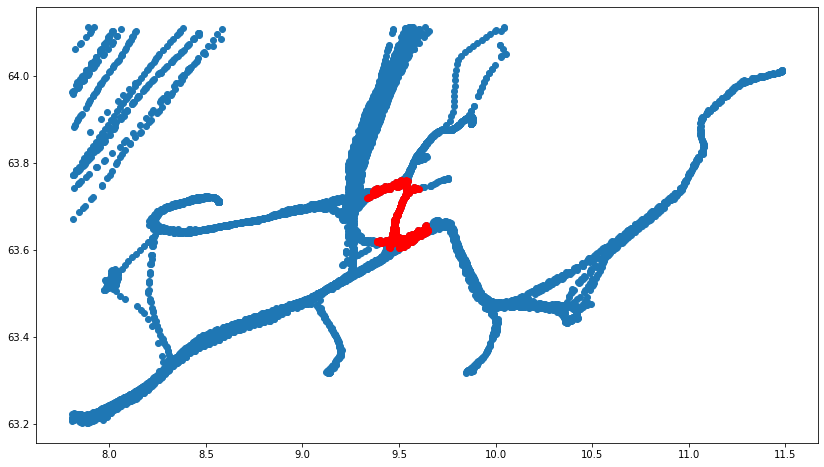

In [49]:
center = df.position.sample().to_crs(epsg=3857).to_numpy()[0]
subset = df.to_crs(epsg=3857).within(center.buffer(20e3))
ax = df.plot()
df[subset].plot(ax=ax, color="red")

In [50]:

within = gpd.GeoSeries(center.buffer(2e3, resolution=4), crs="epsg:3857").to_crs("wgs84").to_numpy()[0]
d = bq.download(lead=8, within=within, limit=1000)

<AxesSubplot:>

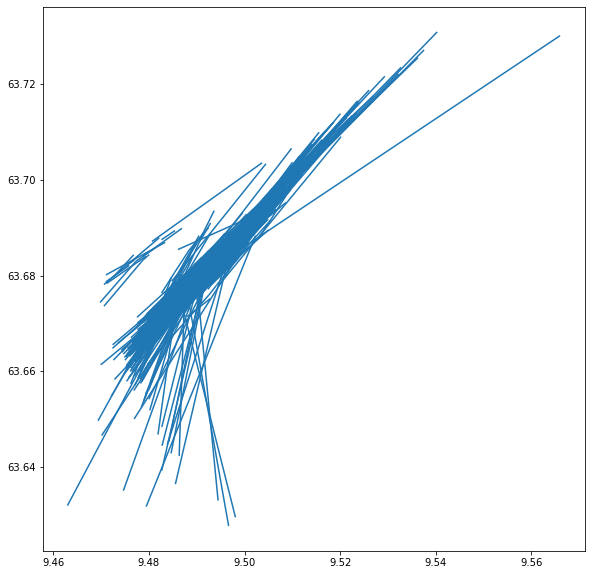

In [51]:
from shapely.geometry import Point, LineString
import geopandas as gpd

p = gpd.GeoSeries(d[["position", "position_1"]].apply(lambda x: LineString(x.tolist()), axis=1))
temp = gpd.GeoDataFrame({"lines": p, "cog": d.cog}, geometry="lines")
temp.plot()

In [62]:
%autoreload
import ais_predict.trajpred.dyngp as dyngp
import numpy as np
X, Y = dyngp.samples_from_lag_n_df(d, 8)
msk = np.random.choice(X.shape[0], X.shape[0]//2)
train_x = X[msk, :]
train_y = Y[msk, :]
#train_dt = dt[::2]dd
test_x = X[~msk, :]
test_y = Y[~msk, :]

print(train_x.shape, train_y.shape)

msk = np.random.choice(train_x.shape[0], 400)
train_x = train_x[msk]
train_y = train_y[msk]

msk = np.random.choice(test_x.shape[0], 10)
#test_dt = dt[1::2]
f, std = dyngp.dyngp_kalman(train_x, train_y, test_x[msk, :], lengthscale=4000, dt=0.1)

(4000, 2) (4000, 2)


/home/haavard/master-thesis-code/ais_predict/trajpred/dyngp.py:92: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(pred_var.diagonal()).reshape(size)


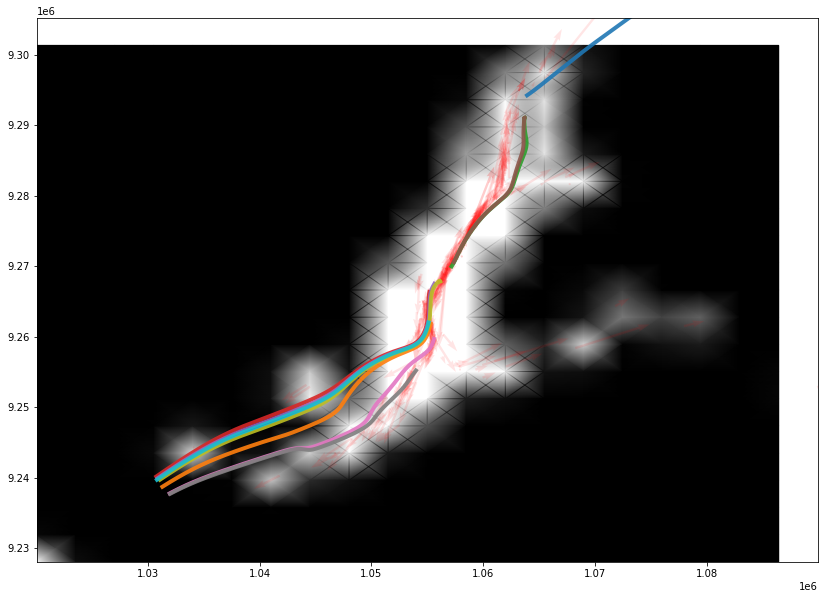

In [63]:
import matplotlib.pyplot as plt
xlim = (min(train_x[:, 0]), max(train_x[:, 0]))
ylim = (min(train_x[:, 1]), max(train_x[:, 1]))

dyngp.plot_grid(train_x, train_y, xlim=xlim, ylim=ylim, lengthscale=3000)
plt.xlim(xlim)
plt.ylim(ylim)
#plt.scatter(*train_y[:, :2].T, color="black", alpha=0.4)

#plt.scatter(*test_x.T, color="red", alpha=0.2)

for t in range(f.shape[0]):
    plt.plot(*f[t].T, alpha=0.9, linewidth=4)